## Imports

In [26]:
import tensorflow as tf
from tfx import v1 as tfx

# TFX libraries
import tensorflow_data_validation as tfdv
import tensorflow_transform as tft
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext

# For performing feature selection
from sklearn.feature_selection import SelectKBest, f_classif

# For feature visualization
import matplotlib.pyplot as plt 
import seaborn as sns

# Utilities
from tensorflow.python.lib.io import file_io
from tensorflow_metadata.proto.v0 import schema_pb2
from google.protobuf.json_format import MessageToDict
from  tfx.proto import example_gen_pb2
from tfx.types import standard_artifacts
from tensorflow_transform.tf_metadata import dataset_metadata, schema_utils
import tensorflow_transform.beam as tft_beam
import os
import pprint
import tempfile
import pandas as pd

# To ignore warnings from TF
tf.get_logger().setLevel('ERROR')

# For formatting print statements
pp = pprint.PrettyPrinter()

# Display versions of TF and TFX related packages
print('TensorFlow version: {}'.format(tf.__version__))
print('TFX version: {}'.format(tfx.__version__))
print('TensorFlow Data Validation version: {}'.format(tfdv.__version__))
print('TensorFlow Transform version: {}'.format(tft.__version__))

TensorFlow version: 2.11.0
TFX version: 1.12.0
TensorFlow Data Validation version: 1.12.0
TensorFlow Transform version: 1.12.0


## Setup variables

In [27]:
# Declare paths to the data
DATA_DIR = '../data'
!ls {DATA_DIR}

TRAINING_DIR = f'{DATA_DIR}/training'
TRAINING_DATA = f'{DATA_DIR}/train.csv'
TEST_DATA = f'{DATA_DIR}/test.csv'
CENSUS_DATA = f'{DATA_DIR}/census_starter.csv'

# Create the directory
!mkdir -p {TRAINING_DIR}

census_starter.csv  sample_submission.csv  train.csv
revealed_test.csv   test.csv		   training


## Feature selection

In [28]:
# Load the dataset to a dataframe
train_df = pd.read_csv(TRAINING_DATA)
test_df = pd.read_csv(TEST_DATA)
census_df = pd.read_csv(CENSUS_DATA)
census_df.head().transpose()

,0,1,2,3,4
pct_bb_2017,76.6,74.5,57.2,62.0,65.8
pct_bb_2018,78.9,78.1,60.4,66.1,68.5
pct_bb_2019,80.6,81.8,60.5,69.2,73.0
pct_bb_2020,82.7,85.1,64.6,76.1,79.6
pct_bb_2021,85.5,87.9,64.6,74.6,81.0
cfips,1001.0,1003.0,1005.0,1007.0,1009.0
pct_college_2017,14.5,20.4,7.6,8.1,8.7
pct_college_2018,15.9,20.7,7.8,7.6,8.1
pct_college_2019,16.1,21.0,7.6,6.5,8.6
pct_college_2020,16.7,20.2,7.3,7.4,8.9


In [29]:
# Preview the dataset
print("----------------- Train data preview ----------------- \n", train_df.head())
print("----------------- Train data types ----------------- \n", train_df.dtypes)
print("----------------- Test data preview ----------------- \n", test_df.head())
print("----------------- Test data types ----------------- \n", test_df.dtypes)
print("----------------- Census data preview ----------------- \n", census_df.head())
print("----------------- Census data types ----------------- \n", census_df.dtypes)

----------------- Train data preview ----------------- 
             row_id  cfips          county    state first_day_of_month  \
0  1001_2019-08-01   1001  Autauga County  Alabama         2019-08-01   
1  1001_2019-09-01   1001  Autauga County  Alabama         2019-09-01   
2  1001_2019-10-01   1001  Autauga County  Alabama         2019-10-01   
3  1001_2019-11-01   1001  Autauga County  Alabama         2019-11-01   
4  1001_2019-12-01   1001  Autauga County  Alabama         2019-12-01   

   microbusiness_density  active  
0               3.007682    1249  
1               2.884870    1198  
2               3.055843    1269  
3               2.993233    1243  
4               2.993233    1243  
----------------- Train data types ----------------- 
 row_id                    object
cfips                      int64
county                    object
state                     object
first_day_of_month        object
microbusiness_density    float64
active                     int64
dtype: o

In [30]:
FEATURES_TO_REMOVE = ["row_id", "first_day_of_month"]
FEATURES_CENSUS = ['pct_bb', 'pct_college', 'pct_foreign_born', 'pct_it_workers', 'median_hh_inc']    

def _pivot_census_all(census_df):
    """This function prepares and melts the census dataframe"""
    outputs = census_df
    
    for category in FEATURES_CENSUS:           
        df_cols = [col for col in census_df.columns if category in col]  # select relevant columns
        df = census_df[df_cols+['cfips']] # subset the dataframe
        # renaming columns
        df_cols = [col[-4:] for col in df.drop('cfips', axis=1).columns]
        df.columns = df_cols+['cfips']
        # melting a dataframe
        df = pd.melt(df, id_vars='cfips', value_vars=['2017','2018','2019','2020','2021'],
                        var_name='year', value_name=category).sort_values('cfips').reset_index(drop=True)
        if category == FEATURES_CENSUS[0]:
            outputs = df
        else:
            outputs = pd.merge(outputs, df, on=['cfips','year'])
    
    outputs.sort_values(['cfips','year'], inplace=True)
    outputs['year'] = outputs['year'].astype('int')
    
    return outputs
        

def preprocessing_fn(inputs, census_df=None):
    """Preprocess input columns into transformed columns."""

    outputs = inputs.copy()

    # Get year and month from first_day_of_month
    outputs['year'] = tf.strings.to_number(tf.strings.substr(outputs['first_day_of_month'], 0, 4), out_type=tf.dtypes.int32)
    outputs['month'] = tf.strings.to_number(tf.strings.substr(outputs['first_day_of_month'], 5, 2), out_type=tf.dtypes.int32)

    # Merge census data
    census_df = _pivot_census_all(census_df)
    outputs = pd.merge(outputs, census_df, on=['cfips','year'])

    # Filter redundant features
    for key in FEATURES_TO_REMOVE:
        del outputs[key]

    return outputs

In [31]:
train_df = preprocessing_fn(train_df, census_df)

In [32]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cfips,90915.0,30376.037640,15143.530076,1001.0,18177.000000,29173.000000,45077.000000,5.604500e+04
microbusiness_density,90915.0,3.773211,4.688673,0.0,1.627148,2.573365,4.491911,2.843400e+02
active,90915.0,6361.414695,32746.923807,0.0,144.000000,484.000000,2106.000000,1.167744e+06
year,90915.0,2020.241379,0.726601,2019.0,2020.000000,2020.000000,2021.000000,2.021000e+03
month,90915.0,7.103448,3.457593,1.0,4.000000,8.000000,10.000000,1.200000e+01
pct_bb,90915.0,78.841119,8.397378,33.3,74.300000,80.000000,84.600000,9.760000e+01
pct_college,90915.0,14.663204,5.785971,0.0,10.500000,13.600000,17.900000,4.540000e+01
pct_foreign_born,90915.0,4.753964,5.712313,0.0,1.400000,2.700000,5.700000,5.400000e+01
pct_it_workers,90915.0,1.300354,0.972842,0.0,0.700000,1.200000,1.700000,1.520000e+01
median_hh_inc,90891.0,56106.693556,15057.966689,17109.0,46352.000000,53963.000000,62865.000000,1.568210e+05


Check yearly and monthly changes 

/tmp/ipykernel_27496/2155615748.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=train_df.groupby('year').mean(),x='year',y='microbusiness_density',ax=axes[0])
/tmp/ipykernel_27496/2155615748.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(data=train_df.groupby('month').mean(),x='month',y='active',ax=axes[1])


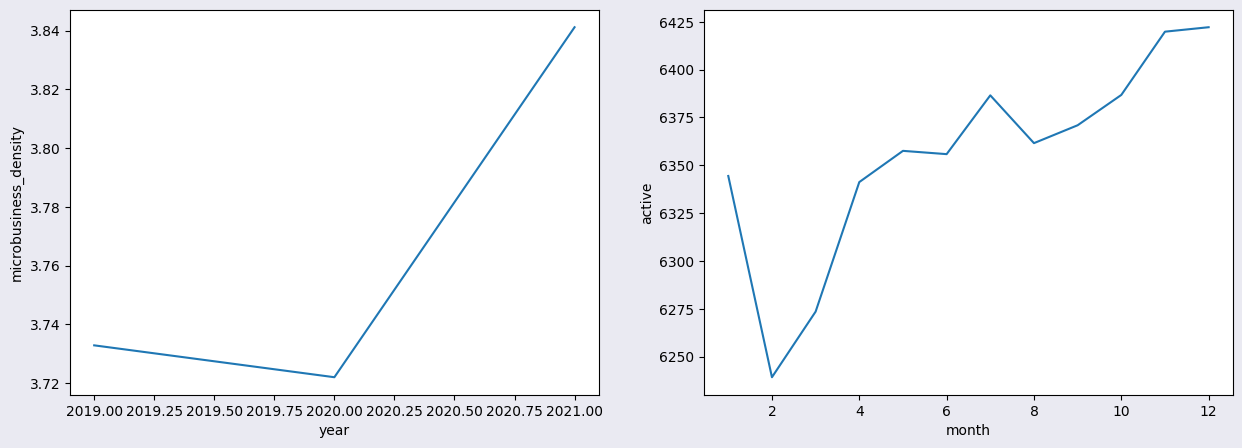

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,5), facecolor='#EAEAF2')
sns.lineplot(data=train_df.groupby('year').mean(),x='year',y='microbusiness_density',ax=axes[0])
sns.lineplot(data=train_df.groupby('month').mean(),x='month',y='active',ax=axes[1])
plt.show()

## Data pipeline and interactive context

In [34]:
# Location of the pipeline metadata store
PIPELINE_DIR = '../pipeline'

# Declare the InteractiveContext and use a local sqlite file as the metadata store.
context = InteractiveContext(pipeline_root=PIPELINE_DIR)

## ExampleGen


In [35]:
# Instantiate ExampleGen with the input CSV dataset
example_gen = tfx.components.CsvExampleGen(input_base=TRAINING_DIR)

# Run the component using the InteractiveContext instance
context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 17
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

## Compute Statistics

In [36]:
# Instantiate StatisticsGen with the ExampleGen ingested dataset
statistics_gen = tfx.components.StatisticsGen(example_gen.outputs['examples'])
    

# Run the component
context.run(statistics_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 18
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [37]:
# Display the results
context.show(statistics_gen.outputs['statistics'])

## Inferring the Schema

In [38]:
# Instantiate SchemaGen with the output statistics from the StatisticsGen
schema_gen = tfx.components.SchemaGen(statistics_gen.outputs['statistics'])

# Run the component
context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 19
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [39]:
# Visualize the output
context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'',INT,required,,-
'active',INT,required,,-
'cfips',INT,required,,-
'county',BYTES,required,,-
'median_hh_inc',FLOAT,required,,-
'microbusiness_density',FLOAT,required,,-
'month',INT,required,,-
'pct_bb',FLOAT,required,,-
'pct_college',FLOAT,required,,-


,Values
Domain,
'state',"'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'"
